## Overview

Given PCA coordinates generate a figure that captures the main structure identified.

In [1]:
import gcsfs
import zarr
import intake
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

In [2]:
from ag3 import release_data
v3 = release_data()

In [3]:
all_meta = v3.load_sample_set_metadata(v3.all_wild_sample_sets)

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [4]:
all_meta.columns

Index(['partner_sample_id', 'contributor', 'country', 'location', 'year',
       'month', 'latitude', 'longitude', 'sex_call', 'sample_set',
       'aim_fraction_colu', 'aim_fraction_arab', 'species_gambcolu_arabiensis',
       'species_gambiae_coluzzii', 'is_arabiensis', 'is_gamb_colu',
       'is_gambiae', 'is_coluzzii'],
      dtype='object')

In [5]:
df_species_samples = all_meta.query("species_gambcolu_arabiensis == 'gamb_colu'")
df_species_samples.head()

partner_sample_id contributor country location  year  month  \
sample_id                                                               
AR0047-C             LUA047  Joao Pinto  Angola   Luanda  2009      4   
AR0049-C             LUA049  Joao Pinto  Angola   Luanda  2009      4   
AR0051-C             LUA051  Joao Pinto  Angola   Luanda  2009      4   
AR0061-C             LUA061  Joao Pinto  Angola   Luanda  2009      4   
AR0078-C             LUA078  Joao Pinto  Angola   Luanda  2009      4   

           latitude  longitude sex_call  sample_set  aim_fraction_colu  \
sample_id                                                                
AR0047-C     -8.884     13.302        F  AG1000G-AO              0.945   
AR0049-C     -8.884     13.302        F  AG1000G-AO              0.933   
AR0051-C     -8.884     13.302        F  AG1000G-AO              0.937   
AR0061-C     -8.884     13.302        F  AG1000G-AO              0.938   
AR0078-C     -8.884     13.302        F  AG1000G-AO              0.926   

           aim_fraction_arab species_gambcolu_arabiensis  \
sample_id                                                  
AR0047-C               0.001                   gamb_colu   
AR0049-C               0.001                   gamb_colu   
AR0051-C               0.002                   gamb_colu   
AR0061-C               0.002                   gamb_colu   
AR0078-C               0.001                   gamb_colu   

          species_gambiae_coluzzii  is_arabiensis  is_gamb_colu  is_gambiae  \
sample_id                                                                     
AR0047-C                  coluzzii          False          True       False   
AR0049-C                  coluzzii          False          True       False   
AR0051-C                  coluzzii          False          True       False   
AR0061-C                  coluzzii          False          True       False   
AR0078-C                  coluzzii          False          True       False   

           is_coluzzii  
sample_id               
AR0047-C          True  
AR0049-C          True  
AR0051-C          True  
AR0061-C          True  
AR0078-C          True

In [6]:
longitude_min = df_species_samples.longitude.min()
longitude_max = df_species_samples.longitude.max()

latitude_min = df_species_samples.latitude.min()
latitude_max = df_species_samples.latitude.max()

longitude_width = longitude_max - longitude_min
latitude_height = latitude_max - latitude_min

In [7]:
BBox = (longitude_min, longitude_max,      
         latitude_min, latitude_max)

In [8]:
# From https://stackoverflow.com/questions/56328254/how-to-make-the-conversion-from-barycentric-coordinates-to-cartesian-coordinates
b = np.array([0.25,0.3,0.45]) # Barycentric coordinates
t = np.transpose(np.array([[0,0],[1,0],[0,1]])) # Triangle
c = t.dot(b)
c

array([0.3 , 0.45])

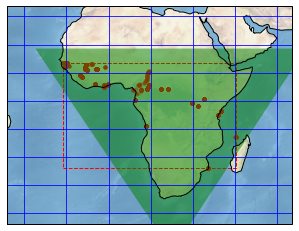

In [10]:
projection=  ccrs.PlateCarree()
transform = ccrs.PlateCarree()

ax = plt.axes(projection=projection)
ax.stock_img()

ax.set_xlim(BBox[0] - 20, BBox[1] + 20)
ax.set_ylim(BBox[2] - 20, BBox[3] + 20)

ax.scatter(
            df_species_samples.longitude,
            df_species_samples.latitude,
            zorder=1, alpha= 0.2, c='r', s=10,
            transform=transform
)

ax.add_patch(
                mpatches.Rectangle(
                    xy=[longitude_min, latitude_min], width=longitude_width, height=latitude_height,
                    edgecolor='red',
                    linestyle='--',
                    fill=False,
                    transform=transform
                )
             )

ax.add_patch(
                mpatches.Polygon(
                    xy=[
                        [longitude_min - 10, latitude_max + 5],
                        [longitude_max + 25, latitude_max + 5],
                        [longitude_max / 2, latitude_min - 30]
                    ],
                    closed=True,
                    facecolor='green',
                    alpha=0.5, 
                    transform=transform
                )

             )

ax.gridlines(color='blue')
ax.coastlines()

plt.show()

In [11]:
from sklearn.decomposition import PCA

In [12]:
X_features = df_species_samples[["latitude", "longitude"]].values
X_features

array([[-8.884, 13.302],
       [-8.884, 13.302],
       [-8.884, 13.302],
       ...,
       [-0.751, 29.701],
       [-0.751, 29.701],
       [-0.751, 29.701]])

In [13]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [14]:
scaler = StandardScaler()
X_features = scaler.fit_transform(X_features)

In [15]:
pca = PCA()
pca.fit_transform(X_features)
pca_variance = pca.explained_variance_

In [16]:
coordinates = pca.transform(X_features)
xv = coordinates[:, 0]
yv = coordinates[:, 1]

In [17]:
import seaborn as sns

In [18]:
ccode = pd.Series(pd.Categorical(df_species_samples.country).codes)
color_pal = sns.color_palette("husl", ccode.max() + 1)
color_pal

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9707505829046977, 0.4626541987597626, 0.26486329418330007),
 (0.8369430560927636, 0.5495828952802333, 0.1952683223448124),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.6430915736746491, 0.6271955086583126, 0.19381135329796756),
 (0.5310702086647983, 0.6569113639885688, 0.1931838276161326),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.1998437102815942, 0.6927711055021983, 0.4485948481767363),
 (0.20582072623426667, 0.6842209016721069, 0.5675558225732941),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.2151139535594307, 0.6700707833028816, 0.7112365203426209),
 (0.22126158707091403, 0.6600977737826563, 0.7915486637100363),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.5392573577708815, 0.5821140171749066, 0.9584212824085171),
 (0.731751635642941, 0.5128186367840487, 0.9581005178234921),
 (0.9082572436765556, 0.40195790729656516, 0.95769

In [19]:
plot_colors = ccode.map(lambda y: color_pal[y]).tolist()

In [20]:
cmap=plt.get_cmap("jet")

In [21]:
pd.Series(xv).describe()

count    2.415000e+03
mean    -1.059194e-16
std      1.341841e+00
min     -1.631477e+00
25%     -1.012803e+00
50%     -2.923016e-01
75%      6.810735e-01
max      3.744037e+00
dtype: float64

In [22]:
xv

array([1.54053053, 1.54053053, 1.54053053, ..., 1.47798619, 1.47798619,
       1.47798619])

In [23]:
xv.min(), xv.max()

(-1.6314769469174524, 3.744036658563635)

In [24]:
xv

array([1.54053053, 1.54053053, 1.54053053, ..., 1.47798619, 1.47798619,
       1.47798619])

In [25]:
xv_for_map_col = (xv - xv.min())/(xv.max() - xv.min())
alt_cmap_colors = cmap(xv_for_map_col)

In [26]:
xv_for_map_col.min(), xv_for_map_col.max()

(0.0, 1.0)

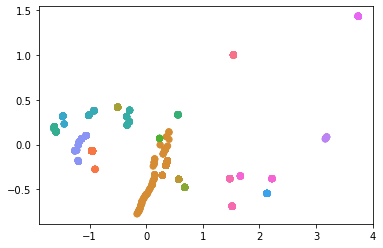

In [27]:
plt.scatter(xv, yv, c=plot_colors)

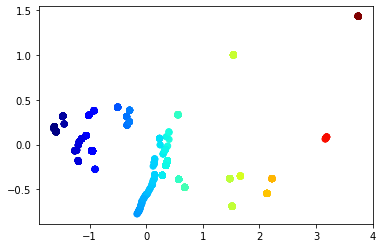

In [28]:
plt.scatter(xv, yv, c=alt_cmap_colors)

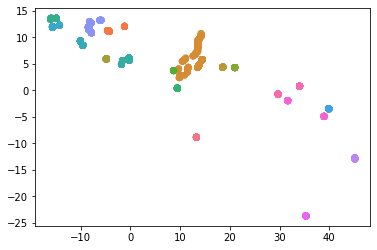

In [29]:
plt.scatter(df_species_samples.longitude, df_species_samples.latitude, c=plot_colors)

In [ ]:
# broadly speaking in an E/W plane.

# 


In [23]:
# https://stackoverflow.com/questions/31967472/smooth-interpolated-tertiary-or-quaternary-colour-scales-e-g-r-g-b-triangle